This notebook implements a Residual Convolutional Neural Network (ResCNN) architecture for predicting Remaining Useful Life (RUL) of aircraft engines using the NASA CMAPSS dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Flatten, Add, Activation, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold
import os

from google.colab import drive

drive.mount('/content/drive')


# Global parameters
WINDOW_SIZE = 30
R_EARLY = 125
BATCH_SIZE = 512
EPOCHS = 200
NUM_FOLDS = 5

Mounted at /content/drive


In [2]:
# Define learning rates and decay parameters for each dataset
LEARNING_PARAMS = {
    'FD001': {'learning_rate': 0.001, 'decay': 0.995},
    'FD002': {'learning_rate': 0.001, 'decay': 0.99},
    'FD003': {'learning_rate': 0.0005, 'decay': 0.995},
    'FD004': {'learning_rate': 0.001, 'decay': 0.995}
}

# Define optimal number of RBBs for each dataset
OPTIMAL_RBB = {
    'FD001': 6,
    'FD002': 3,
    'FD003': 4,
    'FD004': 2
}

# Function to build a Residual Building Block
def residual_block(x, filters, kernel_size, block_id):
    """
    Implements the RBB-2 type Residual Block from the paper
    """
    # Shortcut path (with conv)
    shortcut = Conv1D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        name=f'shortcut_conv_{block_id}'
    )(x)
    shortcut = BatchNormalization(name=f'shortcut_bn_{block_id}')(shortcut)

    # Main path
    conv1 = Conv1D(
        filters=filters,
        kernel_size=kernel_size,
        strides=1,
        padding='same',
        name=f'conv1_{block_id}'
    )(x)
    conv1 = BatchNormalization(name=f'bn1_{block_id}')(conv1)
    conv1 = Activation('tanh', name=f'tanh1_{block_id}')(conv1)

    conv2 = Conv1D(
        filters=filters,
        kernel_size=kernel_size,
        strides=1,
        padding='same',
        name=f'conv2_{block_id}'
    )(conv1)
    conv2 = BatchNormalization(name=f'bn2_{block_id}')(conv2)
    conv2 = Activation('tanh', name=f'tanh2_{block_id}')(conv2)

    conv3 = Conv1D(
        filters=filters,
        kernel_size=kernel_size,
        strides=1,
        padding='same',
        name=f'conv3_{block_id}'
    )(conv2)
    conv3 = BatchNormalization(name=f'bn3_{block_id}')(conv3)

    # Add shortcut to main path
    out = Add(name=f'add_{block_id}')([conv3, shortcut])
    out = Activation('tanh', name=f'out_tanh_{block_id}')(out)

    return out

# Function to build the ResCNN model
def build_rescnn(num_rbb=6, num_sensors=14, learning_rate=0.001, decay=0.995):
    """
    Builds the Residual CNN model with specified number of Residual Building Blocks
    """
    inputs = Input(shape=(WINDOW_SIZE, num_sensors), name='input')

    # First Conv layer
    x = Conv1D(
        filters=5,
        kernel_size=7,
        strides=1,
        padding='same',
        name='first_conv'
    )(inputs)
    x = Activation('tanh', name='first_tanh')(x)

    # Add Residual Building Blocks
    for i in range(num_rbb):
        x = residual_block(x, filters=3, kernel_size=5, block_id=i)

    # Flatten and FC layers
    x = Flatten(name='flatten')(x)
    x = Dropout(0.3, name='dropout1')(x)
    x = Dense(100, activation='tanh', name='fc1')(x)
    x = Dropout(0.3, name='dropout2')(x)

    # Output layer
    outputs = Dense(1, name='output')(x)

    # Create and compile model
    model = Model(inputs=inputs, outputs=outputs, name='ResCNN')
    model.compile(
        optimizer=Adam(learning_rate=learning_rate, decay=decay),
        loss='mse',
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )

    return model

# Scoring function
def score_function(y_true, y_pred):
    """
    PHM 2008 Data Challenge scoring function as defined in the paper
    """
    h = y_pred - y_true

    scores = []
    for hi in h:
        if hi < 0:
            scores.append(np.exp(-hi/13) - 1)
        else:
            scores.append(np.exp(hi/10) - 1)

    return np.sum(scores)

# Function to ensemble predictions from multiple models
def ensemble_predict(models, X):
    """
    Combines predictions from multiple models
    """
    all_preds = []
    for model in models:
        preds = model.predict(X)
        all_preds.append(preds)

    # Average predictions
    avg_preds = np.mean(np.array(all_preds), axis=0)
    return avg_preds

# Function to train an ensemble model for a specific dataset
def train_ensemble_model(X_train, y_train, X_val, y_val, dataset_name):
    """
    Train an ensemble model for a specific dataset
    """
    num_rbb = OPTIMAL_RBB[dataset_name]
    lr_params = LEARNING_PARAMS[dataset_name]
    num_sensors = X_train.shape[2]

    print(f"\nTraining ensemble for {dataset_name} with {num_rbb} RBBs...")

    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
    fold_models = []

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    ]

    fold = 1
    for train_idx, val_idx in kf.split(X_train):
        print(f"Training fold {fold}/{NUM_FOLDS}")
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        # Build and train model
        model = build_rescnn(
            num_rbb=num_rbb,
            num_sensors=num_sensors,
            learning_rate=lr_params['learning_rate'],
            decay=lr_params['decay']
        )

        history = model.fit(
            X_fold_train, y_fold_train,
            validation_data=(X_fold_val, y_fold_val),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=callbacks,
            verbose=0
        )

        # Print fold results
        val_loss = history.history['val_loss'][-1]
        val_rmse = history.history['val_rmse'][-1]
        print(f"Fold {fold} results: val_loss={val_loss:.4f}, val_rmse={val_rmse:.4f}")

        # Save model
        fold_models.append(model)
        fold += 1

    # Evaluate ensemble on validation set
    val_preds = ensemble_predict(fold_models, X_val)
    val_rmse = np.sqrt(np.mean((val_preds.flatten() - y_val) ** 2))
    val_score = score_function(y_val, val_preds.flatten())

    print(f"\n{dataset_name} Validation Results:")
    print(f"RMSE: {val_rmse:.4f}")
    print(f"Score: {val_score:.4f}")

    return fold_models

# Function to evaluate trained ensemble on test set
def evaluate_test_set(models, X_test, y_test, dataset_name):
    """
    Evaluate trained ensemble on test set
    """
    # Generate predictions
    test_preds = ensemble_predict(models, X_test)

    # Calculate metrics
    test_rmse = np.sqrt(np.mean((test_preds.flatten() - y_test) ** 2))
    test_score = score_function(y_test, test_preds.flatten())

    print(f"\n{dataset_name} Test Results:")
    print(f"RMSE: {test_rmse:.4f}")
    print(f"Score: {test_score:.4f}")

    # Create and save plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, test_preds, alpha=0.5)
    plt.plot([0, R_EARLY], [0, R_EARLY], 'r--')
    plt.xlabel('Actual RUL')
    plt.ylabel('Predicted RUL')
    plt.title(f'{dataset_name} Test Set: Predictions vs. Actual')
    plt.xlim(0, R_EARLY)
    plt.ylim(0, R_EARLY)
    plt.grid(True)
    plt.savefig(f'{dataset_name}_test_predictions.png')
    plt.close()

    return test_rmse, test_score, test_preds

# Optional function to save models
def save_models(models, dataset_name, path="models/"):
    """
    Save trained models to disk
    """
    # Create directory if it doesn't exist
    if not os.path.exists(path):
        os.makedirs(path)

    dataset_path = os.path.join(path, dataset_name)
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)

    for i, model in enumerate(models):
        model.save(os.path.join(dataset_path, f"fold_{i+1}.h5"))

    print(f"Saved {len(models)} models for {dataset_name} to {dataset_path}")



Processing dataset: FD001
Train data shape: (11475, 30, 15)
Validation data shape: (2869, 30, 15)
Test data shape: (100, 30, 15)

Training ensemble for FD001 with 6 RBBs...
Training fold 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Fold 1 results: val_loss=235.5681, val_rmse=15.3482
Training fold 2/5
Fold 2 results: val_loss=261.5468, val_rmse=16.1724
Training fold 3/5
Fold 3 results: val_loss=182.3724, val_rmse=13.5045
Training fold 4/5
Fold 4 results: val_loss=196.8604, val_rmse=14.0307
Training fold 5/5
Fold 5 results: val_loss=219.5527, val_rmse=14.8173
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step

FD001 Validation Results:
RMSE: 16.1284
Score: 13601.0941
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step

FD001 Test Results:
RMSE: 13.5140
Score: 334.9897

Processing dataset: FD002
Train data shape: (29881, 30, 16)
Validation data shape: (7471, 30, 16)
Test data shape: (259, 30, 16)

Training ensemble for FD002 with

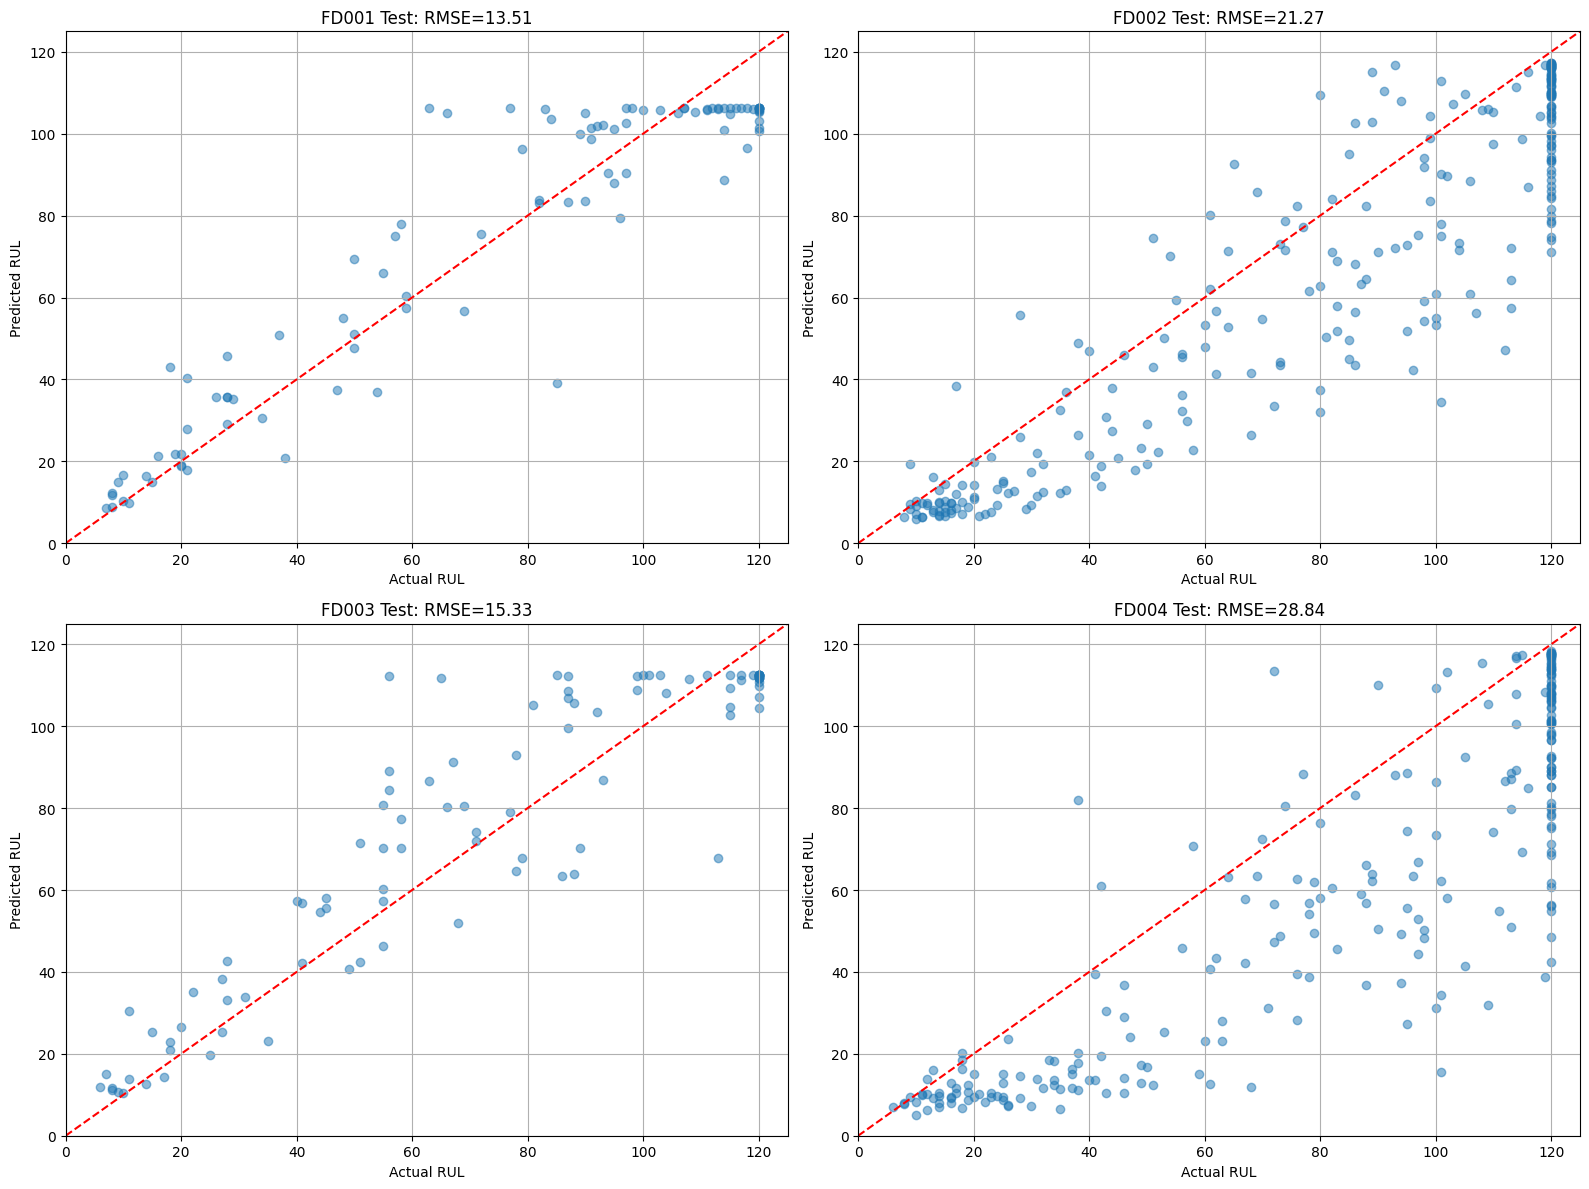

In [3]:
# Main execution loop for all datasets
results = {}

for dataset in ['FD001', 'FD002', 'FD003', 'FD004']:
    print(f"\n{'='*50}")
    print(f"Processing dataset: {dataset}")
    print(f"{'='*50}")

    # Load data
    data_path = '/content/drive/MyDrive/Colab Notebooks/I Learn Deep/tensors/'
    X_train = np.load(f'{data_path}{dataset}_X_augmented.npy')
    y_train = np.load(f'{data_path}{dataset}_y_augmented.npy')
    test_data = np.load(f'{data_path}{dataset}_test_windows.npz')
    X_test = test_data['X_test']
    y_test = test_data['y_test']

    # Define validation split
    val_split = 0.2
    split_idx = int(len(X_train) * (1 - val_split))
    X_val = X_train[split_idx:]
    y_val = y_train[split_idx:]
    X_train_split = X_train[:split_idx]
    y_train_split = y_train[:split_idx]

    print(f"Train data shape: {X_train_split.shape}")
    print(f"Validation data shape: {X_val.shape}")
    print(f"Test data shape: {X_test.shape}")

    # Train ensemble model
    ensemble_models = train_ensemble_model(X_train_split, y_train_split, X_val, y_val, dataset)

    # Evaluate on test set
    test_rmse, test_score, test_preds = evaluate_test_set(ensemble_models, X_test, y_test, dataset)

    # Optionally save models
    # save_models(ensemble_models, dataset)

    # Store results
    results[dataset] = {
        'rmse': test_rmse,
        'score': test_score,
        'predictions': test_preds,
        'actual': y_test
    }

# Create a summary of results
summary_df = pd.DataFrame({
    'Dataset': list(results.keys()),
    'RMSE': [results[k]['rmse'] for k in results.keys()],
    'Score': [results[k]['score'] for k in results.keys()]
})

print("\nSummary of Test Results:")
print(summary_df)

# Optionally save the summary
summary_df.to_csv('test_results_summary.csv', index=False)

# Create a final combined plot with all 4 datasets
plt.figure(figsize=(16, 12))

for i, dataset in enumerate(['FD001', 'FD002', 'FD003', 'FD004']):
    plt.subplot(2, 2, i+1)
    plt.scatter(results[dataset]['actual'], results[dataset]['predictions'], alpha=0.5)
    plt.plot([0, R_EARLY], [0, R_EARLY], 'r--')
    plt.xlabel('Actual RUL')
    plt.ylabel('Predicted RUL')
    plt.title(f'{dataset} Test: RMSE={results[dataset]["rmse"]:.2f}')
    plt.xlim(0, R_EARLY)
    plt.ylim(0, R_EARLY)
    plt.grid(True)

plt.tight_layout()
plt.savefig('all_datasets_comparison.png')
plt.show()